# Coach Slide-Ready Workbook

This notebook is optimized for PowerPoint drafting.
Each section outputs copy/paste text and preformatted tables.


## 0. Setup and Tuned Threshold Model
- Uses the preferred model preset for speed bands, HSR, accel/decel, and rest segmentation.
- Exports text blocks to `outputs/slide_text/` and tables to `outputs/tables/`.

In [1]:
import pandas as pd
from IPython.display import display

from browns_tracking.metrics import (
    compute_peak_demand_timeseries,
    peak_distance_table,
    summarize_speed_bands,
    top_non_overlapping_windows,
    session_extrema_table,
)
from browns_tracking.config import default_project_paths
from browns_tracking.pipeline import load_tracking_data, summarize_session
from browns_tracking.presets import preferred_performance_model
from browns_tracking.presentation import (
    build_slide_1_snapshot_text,
    coach_extrema_table,
    coach_peak_distance_table,
    coach_segment_table,
    coach_speed_band_table,
    write_slide_text,
)
from browns_tracking.segmentation import detect_segments, summarize_segments
from browns_tracking.visuals import (
    plot_intensity_timeline,
    plot_movement_map,
    plot_peak_demand_summary,
    save_figure,
)

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 220)

In [2]:
paths = default_project_paths()
DATA_PATH = paths.data_file
OUTPUT_DIR = paths.output_dir
FIG_DIR = OUTPUT_DIR / 'figures'
TABLE_DIR = OUTPUT_DIR / 'tables'
TEXT_DIR = OUTPUT_DIR / 'slide_text'
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
TEXT_DIR.mkdir(parents=True, exist_ok=True)
model = preferred_performance_model()

pd.Series({
    'Model': model.name,
    'Rationale': model.rationale,
    'HSR threshold (mph)': model.peak_demand_config.hsr_threshold_mph,
    'Accel threshold (m/s^2)': model.peak_demand_config.accel_threshold_ms2,
    'Decel threshold (m/s^2)': model.peak_demand_config.decel_threshold_ms2,
    'Rest threshold (mph)': model.segmentation_config.rest_speed_threshold_mph,
    'Rest min duration (s)': model.segmentation_config.rest_min_duration_s,
}, name='value').to_frame()

,value
Model,Balanced Football Session Model v1
Rationale,"Uses coach-readable absolute zones, moderate H..."
HSR threshold (mph),13.0
Accel threshold (m/s^2),3.0
Decel threshold (m/s^2),-3.0
Rest threshold (mph),1.2
Rest min duration (s),25.0


## 1. Run Core Analysis Once

In [3]:
df = load_tracking_data(DATA_PATH)
session_summary = summarize_session(df)

abs_bands = list(model.absolute_speed_bands)
speed_band_summary = summarize_speed_bands(df, abs_bands)

peak_cfg = model.peak_demand_config
rolling = compute_peak_demand_timeseries(df, peak_cfg)
distance_table = peak_distance_table(rolling, peak_cfg.distance_windows_s)
top_windows = top_non_overlapping_windows(rolling, 'distance_60s_yd', window_s=60, top_n=3)
extrema = session_extrema_table(df)

seg_df, segment_boundaries = detect_segments(df, model.segmentation_config)
segment_summary = summarize_segments(seg_df, speed_bands=abs_bands)

session_summary

{'rows': 65410,
 'start_ts_utc': '2025-10-09 18:20:00.200000+00:00',
 'end_ts_utc': '2025-10-09 20:12:13.100000+00:00',
 'duration_s': 6732.9,
 'sampling_gap_count': 6,
 'distance_yd_from_speed': 4840.750775732611,
 'distance_yd_from_xy': 4909.613797987494,
 'mean_speed_mph': 1.513462397257876,
 'peak_speed_mph': 18.712385351007633,
 'mean_accel_ms2': -0.015546701065684971,
 'peak_accel_ms2': 4.933548130119479,
 'peak_decel_ms2': -5.117768878273345}

## 2. Slide 1: Session Snapshot (Copy/Paste Text)

In [4]:
slide1_text = build_slide_1_snapshot_text(
    session_summary,
    hsr_threshold_mph=peak_cfg.hsr_threshold_mph,
)
print(slide1_text)
write_slide_text(TEXT_DIR / 'slide_1_session_snapshot.txt', slide1_text)

Session Snapshot
- Duration: 112.2 min
- Total distance: 4,841 yd
- Mean speed: 1.51 mph
- Peak speed: 18.71 mph
- Peak accel/decel: 4.93 / -5.12 m/s^2
- HSR threshold for this report: 13.0 mph
- Sampling gaps (>0.15 s): 6


## 3. Slide 2: Workload by Speed Zone

In [5]:
slide2_table = coach_speed_band_table(speed_band_summary)
display(slide2_table)
slide2_table.to_csv(TABLE_DIR / 'slide_2_speed_zone_table.csv', index=False)

top_zone = slide2_table.sort_values('Distance (yd)', ascending=False).iloc[0]
slide2_text = (
    'Speed Zone Takeaways\n'
    f"- Largest distance accumulation: {top_zone['Zone']} ({top_zone['Distance (%)']:.1f}% of total distance).\n"
    f"- HSR/Sprint thresholds begin at {peak_cfg.hsr_threshold_mph:.1f} mph and 16.0 mph, respectively."
)
print(slide2_text)
write_slide_text(TEXT_DIR / 'slide_2_speed_zone_takeaways.txt', slide2_text)

,Zone,Distance (yd),Distance (%),Time (s),Time (%),Mean speed (mph)
0,Walk,2486.1,51.4,5879.5,87.3,0.89
1,Cruise,1696.8,35.1,741.4,11.0,4.68
2,Run,441.1,9.1,82.9,1.2,10.88
3,HSR,132.2,2.7,19.2,0.3,14.09
4,Sprint,84.4,1.7,10.0,0.1,17.27


Speed Zone Takeaways
- Largest distance accumulation: Walk (51.4% of total distance).
- HSR/Sprint thresholds begin at 13.0 mph and 16.0 mph, respectively.


## 4. Slide 3: Peak Demands

In [6]:
slide3_distance = coach_peak_distance_table(distance_table)
slide3_extrema = coach_extrema_table(extrema)
slide3_top_windows = top_windows[['window_start_utc', 'window_end_utc', 'value']].copy()
slide3_top_windows = slide3_top_windows.rename(
    columns={'window_start_utc': 'Start (UTC)', 'window_end_utc': 'End (UTC)', 'value': 'Distance in 60s (yd)'}
)
slide3_top_windows['Start (UTC)'] = pd.to_datetime(slide3_top_windows['Start (UTC)']).dt.strftime('%H:%M:%S')
slide3_top_windows['End (UTC)'] = pd.to_datetime(slide3_top_windows['End (UTC)']).dt.strftime('%H:%M:%S')
slide3_top_windows['Distance in 60s (yd)'] = slide3_top_windows['Distance in 60s (yd)'].round(1)

display(slide3_distance)
display(slide3_extrema)
display(slide3_top_windows)

slide3_distance.to_csv(TABLE_DIR / 'slide_3_peak_distance_table.csv', index=False)
slide3_extrema.to_csv(TABLE_DIR / 'slide_3_extrema_table.csv', index=False)
slide3_top_windows.to_csv(TABLE_DIR / 'slide_3_top_windows_table.csv', index=False)

best_window = slide3_top_windows.iloc[0]
slide3_text = (
    'Peak Demand Takeaways\n'
    f"- Best 1-min demand: {best_window['Distance in 60s (yd)']:.1f} yd from {best_window['Start (UTC)']} to {best_window['End (UTC)']} UTC.\n"
    f"- Max speed: {slide3_extrema.loc[slide3_extrema['Metric'] == 'Max speed (mph)', 'Value'].iloc[0]:.2f} mph.\n"
    f"- Max accel/decel events reported using thresholds ±{peak_cfg.accel_threshold_ms2:.1f} m/s^2."
)
print(slide3_text)
write_slide_text(TEXT_DIR / 'slide_3_peak_takeaways.txt', slide3_text)

,Window,Best distance (yd),Start (UTC),End (UTC)
0,30s,98.8,19:18:54,19:19:24
1,1m,135.1,19:18:09,19:19:09
2,3m,317.3,19:16:25,19:19:25
3,5m,432.4,19:15:50,19:20:50


,Metric,Value,Time (UTC)
0,Max speed (mph),18.71,20:08:53
1,Max accel (m/s^2),4.93,19:17:18
2,Max decel (m/s^2),-5.12,19:16:41


,Start (UTC),End (UTC),Distance in 60s (yd)
0,19:18:09,19:19:09,135.1
1,19:07:19,19:08:19,133.1
2,19:41:58,19:42:58,133.1


Peak Demand Takeaways
- Best 1-min demand: 135.1 yd from 19:18:09 to 19:19:09 UTC.
- Max speed: 18.71 mph.
- Max accel/decel events reported using thresholds ±3.0 m/s^2.


## 5. Slide 4: Session Blocks (Unlabeled Drills)

In [7]:
slide4_table = coach_segment_table(segment_summary, top_n=8)
display(slide4_table)
slide4_table.to_csv(TABLE_DIR / 'slide_4_segment_table.csv', index=False)

slide4_text = (
    'Session Block Takeaways\n'
    '- Blocks are algorithmic segments based on gaps, sustained rest, and intensity change points.\n'
    '- Use these to discuss likely warm-up, work, and lower-intensity transitions without over-claiming drill labels.'
)
print(slide4_text)
write_slide_text(TEXT_DIR / 'slide_4_segment_takeaways.txt', slide4_text)

,Block,Duration (min),Distance (yd),Mean speed (mph),Peak speed (mph),Peak 60s distance (yd)
0,Block 53,7.37,518.2,2.40,13.51,127.7
1,Block 46,6.94,510.0,2.50,11.52,110.9
2,Block 39,5.06,434.7,2.93,17.33,135.1
3,Block 36,5.95,420.7,2.41,17.12,133.1
4,Block 64,4.07,337.2,2.83,18.71,114.2
5,Block 48,4.66,325.7,2.38,14.98,133.1
6,Block V,3.29,230.2,2.39,13.10,94.6
7,Block 27,3.54,220.4,2.12,12.26,74.5


Session Block Takeaways
- Blocks are algorithmic segments based on gaps, sustained rest, and intensity change points.
- Use these to discuss likely warm-up, work, and lower-intensity transitions without over-claiming drill labels.


## 6. Slide Figure Exports (PNG)

('Saved',
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_movement_map.png'),
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_intensity_timeline.png'),
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_peak_demand_summary.png'))

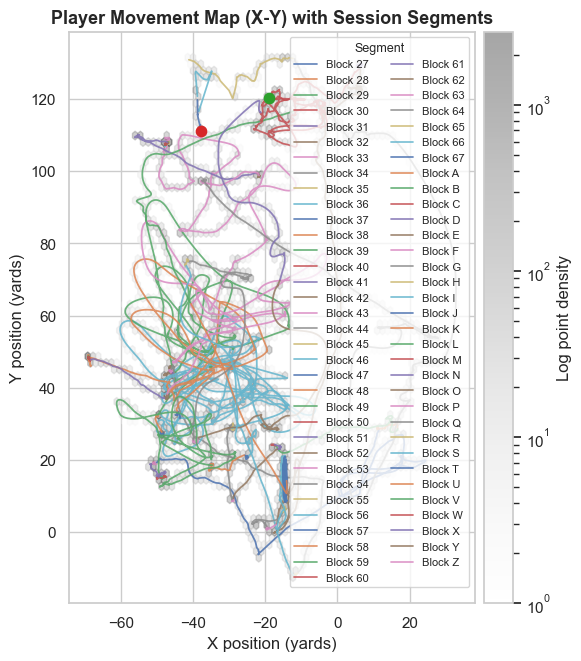

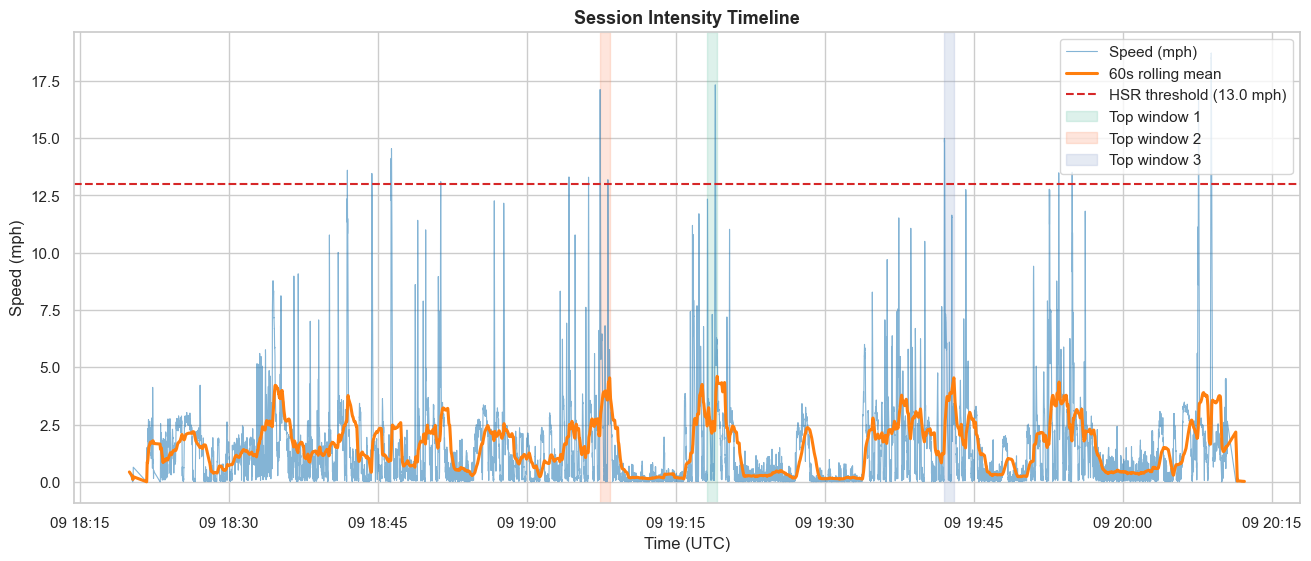

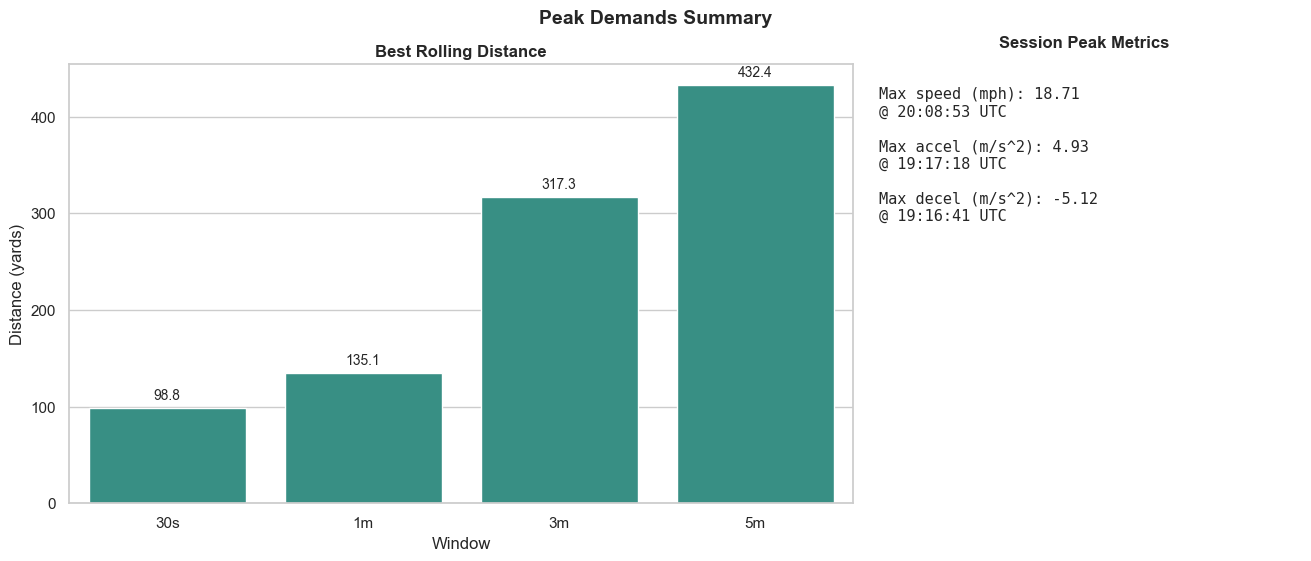

In [8]:
fig1, _ = plot_movement_map(seg_df)
fig2, _ = plot_intensity_timeline(
    seg_df,
    top_windows=top_windows,
    hsr_threshold_mph=peak_cfg.hsr_threshold_mph,
)
fig3, _ = plot_peak_demand_summary(distance_table, extrema)

save_figure(fig1, FIG_DIR / 'coach_slide_movement_map.png')
save_figure(fig2, FIG_DIR / 'coach_slide_intensity_timeline.png')
save_figure(fig3, FIG_DIR / 'coach_slide_peak_demand_summary.png')

('Saved', FIG_DIR / 'coach_slide_movement_map.png', FIG_DIR / 'coach_slide_intensity_timeline.png', FIG_DIR / 'coach_slide_peak_demand_summary.png')

## 7. PowerPoint Copy Checklist
- Text blocks: `outputs/slide_text/*.txt`
- Slide tables: `outputs/tables/slide_*.csv`
- Slide figures: `outputs/figures/coach_slide_*.png`